In [1]:
!pip install -q tokenizer_xm
!pip install -q wordcloud
!pip install -q nltk -q
!pip install -q contractions
!pip install -q emoji

# **Data Science Lab: process and methods (2021/22)**


Project Assignment
January Call, A.Y. 2021/2022

---
Ionut Cosmin Nedescu

Politecnico di Torino

Student id: s292495

s292495@studenti.polito.it

---

Andrea Parolin

Politecnico di Torino

Student id: s291462 

s291462@studenti.polito.it

---


In [55]:
#General
import html
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

#NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

#Sklearn - Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
#Sklearn - Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#Sklearn - Model Score
from sklearn.metrics import accuracy_score, classification_report, f1_score
#Sklearn - Model Parameters Search
from sklearn.model_selection import GridSearchCV, train_test_split

# ML Other models
from xgboost import XGBClassifier

#Utility and Visualizer
from wordcloud import WordCloud
import contractions

nltk.download('stopwords')                  # list of stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df_dev = pd.read_csv("DSL2122_january_dataset/development.csv")
df_dev.head()

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


# Data exploration


In [4]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
sentiment    224994 non-null int64
ids          224994 non-null int64
date         224994 non-null object
flag         224994 non-null object
user         224994 non-null object
text         224994 non-null object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


In [5]:
# Count duplicates
duplicates_count = pd.DataFrame(df_dev.duplicated(subset=['text']), columns=['Duplicates_Count'])
duplicates_count.groupby('Duplicates_Count').size()

Duplicates_Count
False    223106
True       1888
dtype: int64

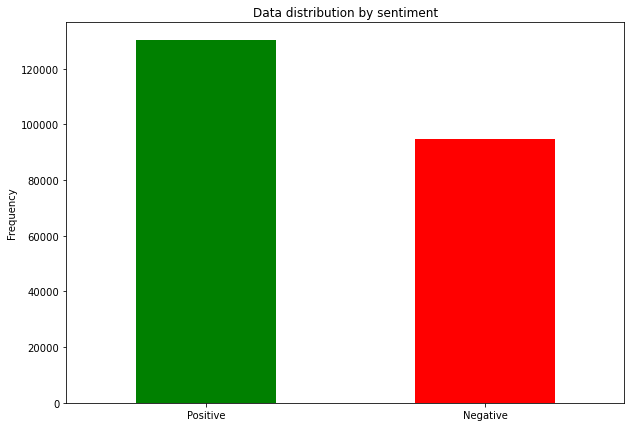

In [6]:
# Visualization of class balance
plt.figure(figsize=(10, 7))
sentiment_distribution= df_dev['sentiment'].value_counts()
sentiment_distribution.index=['Positive','Negative']
sentiment_distribution.plot(kind='bar', title='Data distribution by sentiment',x = 'Sentiment', color=['green','red'])
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=0)
plt.savefig('figures/class_balance.png',dpi=100, bbox_inches='tight', pad_inches=0)

### Tweet length

Positive text mean length: 76.54520310087048
Positive text min length: 7
Positive text max length: 359

Negative text mean length: 79.17060851777259
Negative text min length: 6
Negative text max length: 348


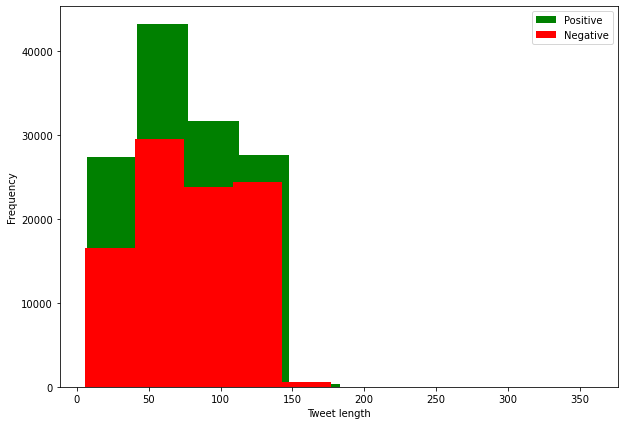

In [7]:
# Mean review length
postive_text = df_dev.loc[df_dev['sentiment'] == 1 ] # Positive mean length
negative_text = df_dev.loc[df_dev['sentiment'] == 0 ] # Negative mean length

# Characterizing distribution

print("Positive text mean length:",postive_text.text.str.len().mean())
print("Positive text min length:",postive_text.text.str.len().min())
print("Positive text max length:",postive_text.text.str.len().max())
plt.figure(figsize=(10,7))
plt.xlabel("Tweet length", fontsize=10)  
plt.ylabel("Frequency", fontsize=10)
plt.grid(False)

postive_text.text.str.len().hist(label = 'Positive',grid=False, color='green')

print()

# characterizing distribution
print("Negative text mean length:",negative_text.text.str.len().mean())
print("Negative text min length:",negative_text.text.str.len().min())
print("Negative text max length:",negative_text.text.str.len().max())
negative_text.text.str.len().hist(color = 'red', label = 'Negative',grid=False)
plt.legend()
plt.savefig('figures/tweet_length.png', dpi=100, bbox_inches='tight', pad_inches=0)

# Data pre-proccessing


In [9]:
# Dict of common tweet slang words
twitter_slang = {'imma': 'i am going to',
 '121': 'one to one',
 'a/s/l': 'age, sex, location',
 'adn': 'any day now',
 'afaik': 'as far as I know',
 'afk': 'away from keyboard',
 'aight': 'alright',
 'alol': 'actually laughing out loud',
 'b4': 'before',
 'b4n': 'bye for now',
 'bak': 'back at the keyboard',
 'bf': 'boyfriend',
 'bff': 'best friends forever',
 'bfn': 'bye for now',
 'bg': 'big grin',
 'bta': 'but then again',
 'btw': 'by the way',
 'cid': 'crying in disgrace',
 'cnp': 'continued in my next post',
 'cp': 'chat post',
 'cu': 'see you',
 'cul': 'see you later',
 'cul8r': 'see you later',
 'cya': 'bye',
 'cyo': 'see you online',
 'dbau': 'doing business as usual',
 'fud': 'fear, uncertainty, and doubt',
 'fwiw': "for what it's worth",
 'fyi': 'for your information',
 'g': 'grin',
 'g2g': 'got to go',
 'ga': 'go ahead',
 'gal': 'get a life',
 'gf': 'girlfriend',
 'gfn': 'gone for now',
 'gmbo': 'giggling my butt off',
 'gmta': 'great minds think alike',
 'h8': 'hate',
 'hagn': 'have a good night',
 'hdop': 'help delete online predators',
 'hhis': 'hanging head in shame',
 'iac': 'in any case',
 'ianal': 'I am not a lawyer',
 'ic': 'I see',
 'idk': "I don't know",
 'imao': 'in my arrogant opinion',
 'imnsho': 'in my not so humble opinion',
 'imo': 'in my opinion',
 'iow': 'in other words',
 'ipn': 'I’m posting naked',
 'irl': 'in real life',
 'jk': 'just kidding',
 'l8r': 'later',
 'ld': 'later, dude',
 'ldr': 'long distance relationship',
 'llta': 'lots and lots of thunderous applause',
 'lmao': 'laugh my ass off',
 'lmirl': "let's meet in real life",
 'lol': 'strong_laugh',
 'ltr': 'longterm relationship',
 'lulab': 'love you like a brother',
 'lulas': 'love you like a sister',
 'luv': 'love',
 'm/f': 'male or female',
 'm8': 'mate',
 'milf': 'mother I would like to fuck',
 'oll': 'online love',
 'omg': 'oh my god',
 'otoh': 'on the other hand',
 'pir': 'parent in room',
 'ppl': 'people',
 'r': 'are',
 'rofl': 'roll on the floor laughing',
 'rpg': 'role playing games',
 'ru': 'are you',
 'shid': 'slaps head in disgust',
 'somy': 'sick of me yet',
 'sot': 'short of time',
 'thanx': 'thanks',
 'thx': 'thanks',
 'ttyl': 'talk to you later',
 'u': 'you',
 'ur': 'you are',
 'uw': 'you’re welcome',
 'wb': 'welcome back',
 'wfm': 'works for me',
 'wibni': "wouldn't it be nice if",
 'wtf': 'what the fuck',
 'wtg': 'way to go',
 'wtgp': 'want to go private',
 'ym': 'young man',
 'gr8': 'great'}

In [10]:
# Functions of preprocessing step
def cleanText(text):
  text = text.lower()  # Convert the text in lower letters
  #text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions - Twitter username allow char,num and underscore.
  text = re.sub(r'#(\S+)', r'\1 ', text)  # Remove hashtags
  text = re.sub(r'RT[\s]+', '', text)  # Remove RT (retweet)
  text = \
    re.sub('(?i)\\b((?:https?://|www\\d{0,3}[.]|[a-z0-9.\\-]+[.][a-z]{2,4}/)(?:[^\\s()<>]+|\\(([^\\s()<>]+|(\\([^\\s()<>]+\\)))*\\))+(?:\\(([^\\s()<>]+|(\\([^\\s()<>]+\\)))*\\)|[^\\s`!()\\[\\]{};:\'".,<>?\xc2\xab\xc2\xbb\xe2\x80\x9c\xe2\x80\x9d\xe2\x80\x98\xe2\x80\x99]))'
         , '', text)  # Remove Links HTTP/HTTPS
  text = text.replace(text, html.unescape(text))  #  Remove HTML
  text = re.sub(r'[0-9]+', '', text)  #  Remove digits
  text = re.sub(r'(.)\1{2,}', r'\1', text)  # Remove more than 2 consecutive equal chars - e.g., Helloooooo world -> Helloo world
  # Negation Handling 
    # Negate every word after a (not,never,no) until puntaction is found by adding a NEG_ 
  text = text + '.'
  transformed = re.sub(r'\b(?:not|never|no)\b[\w\s]+[^\w\s]',
             lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2'
             , match.group(0)), text, flags=re.IGNORECASE)
  text = transformed
  text = re.sub(r'\b(a*ha+h[ha]*|o?l+o+l+[ol]*)\b','strong_laugh ',text) # Replace string like 'ahahhaha'/'loooool' with 'strong_laugh'
  text = re.sub(r'\b(h*ha+h[ha]*|o?l+o+l+[ol]*)\b','strong_laugh ',text) # Replace string like 'ahahhaha'/'loooool' with 'strong_laugh'

  return text

def handle_emoji(text):
  # Handle the emoticons by replacing them with a string 'EMO_POS' for positives one, and 'EMO_NEG' for negatives
  text = re.sub(r"(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))", ' EMO_POS ', text)
  text = re.sub(r"(:\s?D|:-D|x-?D|X-?D)", ' EMO_POS ', text)
  text = re.sub(r"(<3|:\*)", ' EMO_POS ', text)
  text = re.sub(r"(;-?\)|;-?D|\(-?;)", ' EMO_POS ', text)
  text = re.sub(r"(:\s?\(|:-\(|\)\s?:|\)-:)", ' EMO_NEG ', text)
  text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)
  return text

def solve_html(text):
    text = text.replace(text, html.unescape(text))
    return text
  
def textPreprocessor(text):
  text = handle_emoji(text) # Handle emoticons
  text = ' '.join([twitter_slang.get(re.sub('[^A-Za-z0-9]+', '',
          x).lower(), x) for x in text.split(' ')]) # Replace common slang with word
  text = ' '.join([contractions.fix(w) for w in text.split(' ')]) # Removes contractions e.g. I dont go -> I do not go
  removeNotUseful = cleanText(text) # Refer to cleanText
  text_final = re.sub('[^A-Za-z_ ]+', ' ', removeNotUseful) # Remove strange characters, only A-Z, a-z chars and underscores are allowed
  return text_final
textPreprocessor("Hellooooo i'm a common tweet!!! We use a lot of slang here ahahahh ahhhh hahahha loooooool @today #now #test")

'hello i am a common tweet  we use a lot of slang here strong_laugh  ah strong_laugh  strong_laugh   today now  test  '

In [11]:
df_dev = df_dev[['sentiment','user','text']]
df_dev.head()

,sentiment,user,text
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,yaseminx3,@PleaseBeMine Something for your iphone
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [13]:
df_dev.drop_duplicates(subset=['text'],inplace=True) # Drop duplicates
df_dev['text'] = df_dev['text'].apply(solve_html)
df_dev = df_dev.drop(df_dev[df_dev['text'].str.len()>140].index) # Remove outliers with more than 140 
df_dev["pre_processed_text"] = df_dev["text"].apply(textPreprocessor)
df_dev.head()

,sentiment,user,text,pre_processed_text
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",missbianca yes talking helps a lot going th...
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,sunshine livingg it i am going to lie on the...
2,1,yaseminx3,@PleaseBeMine Something for your iphone,pleasebemine something for your iphone
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,gabrielsaporta could not NEG_get NEG_in NEG_t...
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,bradiewebbstack aw is andy being mean again ...


### WordCloud of positive and negative sentiment

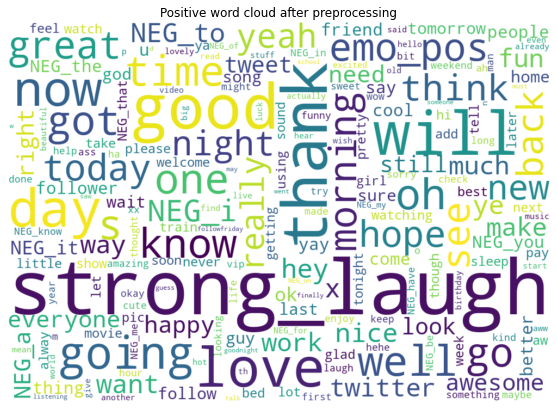

In [15]:
positive_words =' '.join([text for text in df_dev['pre_processed_text'][df_dev['sentiment'] == 1]])
wordcloud = WordCloud(width=1000, height=700,background_color='white', random_state = 0, max_font_size = 160, collocations=False).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive word cloud after preprocessing')
plt.savefig("figures/word_cloud.png", dpi=100, bbox_inches='tight', pad_inches=0)

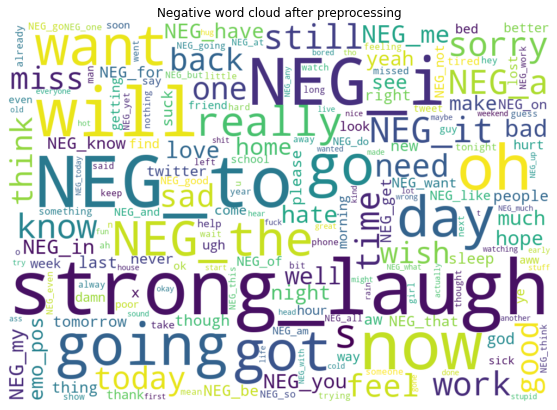

In [16]:
neg_words =' '.join([text for text in df_dev['pre_processed_text'][df_dev['sentiment'] == 0]])

wordcloud = WordCloud(width=1000, height=700,background_color='white', random_state = 0, max_font_size = 160, collocations=False).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative word cloud after preprocessing')
plt.savefig("figures/word_cloud_neg.png", dpi=100, bbox_inches='tight', pad_inches=0)


Positive text mean length: 75.99698168112621
Positive text min length: 7
Positive text max length: 140

Negative text mean length: 78.99238105386542
Negative text min length: 6
Negative text max length: 140


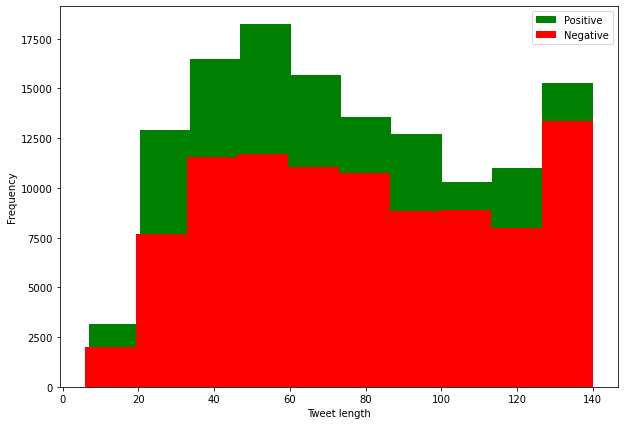

In [17]:
# Mean review length
postive_text = df_dev.loc[df_dev['sentiment'] == 1 ] # Positive mean length
negative_text = df_dev.loc[df_dev['sentiment'] == 0 ] # Negative mean length

# Characterizing distribution

print("Positive text mean length:",postive_text.text.str.len().mean())
print("Positive text min length:",postive_text.text.str.len().min())
print("Positive text max length:",postive_text.text.str.len().max())
plt.figure(figsize=(10,7))
plt.xlabel("Tweet length", fontsize=10)  
plt.ylabel("Frequency", fontsize=10)
plt.grid(False)

postive_text.text.str.len().hist(label = 'Positive',grid=False, color='green')

print()


# characterizing distribution
print("Negative text mean length:",negative_text.text.str.len().mean())
print("Negative text min length:",negative_text.text.str.len().min())
print("Negative text max length:",negative_text.text.str.len().max())
negative_text.text.str.len().hist(color = 'red', label = 'Negative',grid=False)
plt.legend()
plt.savefig('figures/tweet_length_after_preproc.png', dpi=100, bbox_inches='tight', pad_inches=0)

In [18]:
df_dev['pre_processed_text'] = df_dev['user'] + ' ' + df_dev['pre_processed_text'] # Union of twitter username and preprocessed text

In [19]:
stemmer = SnowballStemmer("english", ignore_stopwords=True) # Refer to https://www.nltk.org/_modules/nltk/stem/snowball.html
df_dev["stemmed"] =  df_dev["pre_processed_text"].apply(lambda x: [stemmer.stem(word) for word in x.split()])
df_dev = df_dev[df_dev['stemmed'].map(lambda x: len(x)>0)] # Drop empty lines
df_dev.head()

,sentiment,user,text,pre_processed_text,stemmed
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",Killandra missbianca yes talking helps a lot...,"[killandra, missbianca, yes, talk, help, a, lo..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,IMlisacowan sunshine livingg it i am going t...,"[imlisacowan, sunshin, livingg, it, i, am, go,..."
2,1,yaseminx3,@PleaseBeMine Something for your iphone,yaseminx3 pleasebemine something for your iph...,"[yaseminx3, pleasebemin, someth, for, your, ip..."
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,no_surprises gabrielsaporta could not NEG_get...,"[no_surpris, gabrielsaporta, could, not, neg_g..."
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,Rhi_ShortStack bradiewebbstack aw is andy bei...,"[rhi_shortstack, bradiewebbstack, aw, is, andi..."


# Vectorizing the final DF

In [20]:
X = df_dev["stemmed"]
y = df_dev["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

In [21]:
#   Bag of words Vectorizer
vectorizer_bow = CountVectorizer(preprocessor=' '.join,ngram_range=(1,3))
vectorizer_bow.fit(X_train)

#   Tf-idf Vectorizer
vectorizer_tfidf = TfidfVectorizer(preprocessor=' '.join,ngram_range=(1,3))
vectorizer_tfidf.fit(X_train)
#   Bag of words -> Train/Text Transformation
X_train_bow = vectorizer_bow.transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)
#   Tf-Idf -> Train/Text Transformation
X_train_tfidf = vectorizer_tfidf.transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [22]:
# ML model Exploration
model_bow = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(criterion='gini',max_depth=5),
    XGBClassifier(objective='binary:logistic'),
    RandomForestClassifier(n_estimators=10,max_depth=5),
    MultinomialNB(),
    LinearSVC(C=1, loss='hinge')
]
model_tfidf = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(criterion='gini',max_depth=5),
    XGBClassifier(objective='binary:logistic',use_label_encoder=False),
    RandomForestClassifier(n_estimators=10,max_depth=5),
    MultinomialNB(),
    LinearSVC(C=1, loss='hinge')
]

In [23]:
prediction_bow = []
y_predicted_train_bow = []
for model in model_bow:
    print(model)
    model.fit(X_train_bow, y_train)
    # Check prediction on trained model
    y_pred_train = model.predict(X_train_bow)
    y_predicted_train_bow.append(y_pred_train)
    # Check on test set
    y_pred = model.predict(X_test_bow)
    prediction_bow.append(y_pred)
    print(classification_report(y_test, y_pred))
    print('---')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     18766
           1       0.84      0.88      0.86     25846

    accuracy                           0.83     44612
   macro avg       0.83      0.82      0.83     44612
weighted avg       0.83      0.83      0.83     44612

---
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,

In [24]:
prediction_bow_model = [type(model).__name__ for model in model_bow] # Model with Specs to only model name
prediction_bow_acc = [accuracy_score(y_test, y_pred) for y_pred in prediction_bow] # Accuracy for BoW

results = pd.DataFrame(prediction_bow_acc,index=prediction_bow_model, columns=['Test_Accuracy_BoW'])
results['Test_F1_BoW'] = [f1_score(y_test,y_pred, average='macro') for y_pred in prediction_bow]
results['Train_F1_BoW'] = [f1_score(y_train,y_pred, average='macro') for y_pred in y_predicted_train_bow]
results['Train_Accuracy_BoW'] = [accuracy_score(y_train,y_pred) for y_pred in y_predicted_train_bow]
results

,Test_Accuracy_BoW,Test_F1_BoW,Train_F1_BoW,Train_Accuracy_BoW
LogisticRegression,0.831122,0.825279,0.999471,0.999484
DecisionTreeClassifier,0.650072,0.573814,0.571640,0.648601
XGBClassifier,0.724088,0.696686,0.698536,0.725477
RandomForestClassifier,0.579418,0.367004,0.367167,0.579392
MultinomialNB,0.809760,0.802745,0.982643,0.983054
LinearSVC,0.829396,0.824114,0.999966,0.999966


In [25]:
prediction_tfidf = []
y_predicted_train_tfidf = []
for model in model_tfidf:
    print(model)
    model.fit(X_train_tfidf, y_train)
    # Check prediction on trained model
    y_pred_train = model.predict(X_train_tfidf)
    y_predicted_train_tfidf.append(y_pred_train)
    # Check on test set
    y_pred = model.predict(X_test_tfidf)
    prediction_tfidf.append(y_pred)
    print(classification_report(y_test, y_pred))
    print('---')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.78      0.79      0.78     18766
           1       0.84      0.84      0.84     25846

    accuracy                           0.82     44612
   macro avg       0.81      0.81      0.81     44612
weighted avg       0.82      0.82      0.82     44612

---
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,

In [26]:
prediction_tfidf_model = [type(model).__name__ for model in model_tfidf] # Model with Specs to only model name
prediction_tfidf_acc = [accuracy_score(y_test, y_pred) for y_pred in prediction_tfidf] # Accuracy for TfIdf

results['Test_Accuracy_TfIdf'] = prediction_tfidf_acc

results['Test_F1_TfIdf'] = [f1_score(y_test,y_pred, average='macro') for y_pred in prediction_tfidf]
results['Train_F1_TfIdf'] = [f1_score(y_train,y_pred, average='macro') for y_pred in y_predicted_train_tfidf]
results['Train_Accuracy_TfIdf'] = [accuracy_score(y_train,y_pred) for y_pred in y_predicted_train_tfidf]
results.to_csv('model_comparison.csv')

### Preliminary Results

In [27]:
results

,Test_Accuracy_BoW,Test_F1_BoW,Train_F1_BoW,Train_Accuracy_BoW,Test_Accuracy_TfIdf,Test_F1_TfIdf,Train_F1_TfIdf,Train_Accuracy_TfIdf
LogisticRegression,0.831122,0.825279,0.999471,0.999484,0.815431,0.811051,0.894723,0.898388
DecisionTreeClassifier,0.650072,0.573814,0.571640,0.648601,0.650004,0.574565,0.573176,0.649363
XGBClassifier,0.724088,0.696686,0.698536,0.725477,0.724200,0.697685,0.699853,0.725998
RandomForestClassifier,0.579418,0.367004,0.367167,0.579392,0.581189,0.371606,0.371856,0.581202
MultinomialNB,0.809760,0.802745,0.982643,0.983054,0.776518,0.753791,0.932633,0.935436
LinearSVC,0.829396,0.824114,0.999966,0.999966,0.832713,0.829284,0.981375,0.981843


<Figure size 864x504 with 0 Axes>

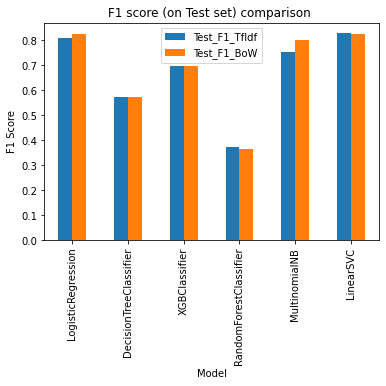

In [28]:
plt.figure(figsize=(12,7))
results.plot( y=['Test_F1_TfIdf','Test_F1_BoW'], kind='bar')
plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.title('F1 score (on Test set) comparison ')

plt.show()

<Figure size 864x504 with 0 Axes>

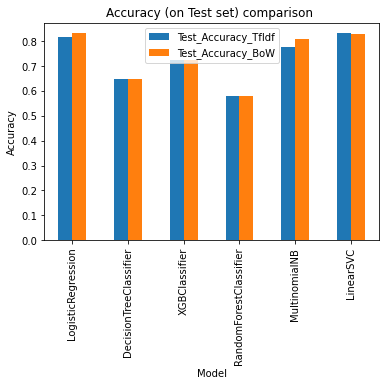

In [29]:
plt.figure(figsize=(12,7))
results.plot( y=['Test_Accuracy_TfIdf','Test_Accuracy_BoW'], kind='bar')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracy (on Test set) comparison ')
plt.show()

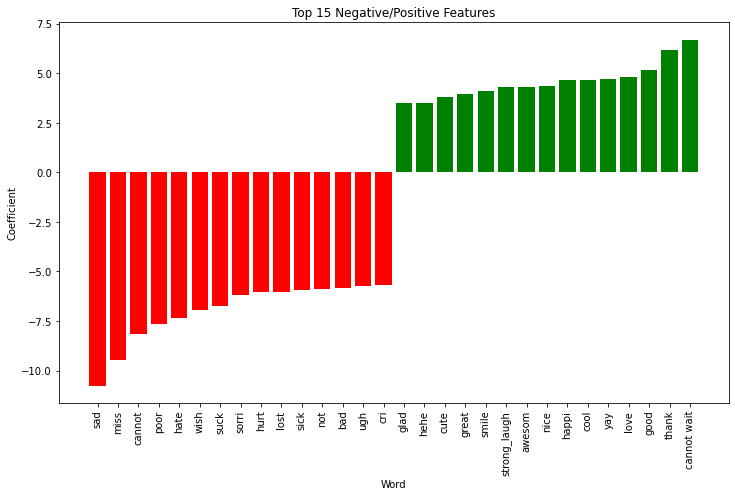

In [30]:
#   Top 20 Feature used by LinearSVC
feature_names = vectorizer_tfidf.get_feature_names() 
coefs_with_fns = sorted(zip(model_tfidf[5].coef_[0], feature_names)) 
word_coefficient=pd.DataFrame(coefs_with_fns)
word_coefficient.columns='coefficient','word'
word_coefficient_sorted = word_coefficient.sort_values(by='coefficient')
word_coefficient_positive = word_coefficient_sorted.tail(15)
word_coefficient_negative = word_coefficient_sorted.head(15)
plt.figure(figsize=(12,7))
plt.bar(word_coefficient_negative['word'],word_coefficient_negative['coefficient'] , color='red')
plt.bar(word_coefficient_positive['word'],word_coefficient_positive['coefficient'] , color='green')
plt.xticks(rotation = 90)
plt.title('Top 15 Negative/Positive Features')
plt.xlabel("Word")
plt.ylabel("Coefficient")
plt.show()

# Fine-Tuning Parameters 

For LinearSVC Classifier using TF-IDF Vectorizer

In [31]:
# We choose the model with the best F1 score and done a fine tuning to find best parameters

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
           ('vect', TfidfVectorizer(preprocessor=' '.join,ngram_range=(1,3))),
           ('clf', LinearSVC(loss='hinge')),
])
parameters = {
'vect__max_df': (0.2, 0.3, 0.4, 0.5),
'clf__C':(0.8, 0.9, 1, 1.1, 1.2)
}

grid_search_svc = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring='f1_macro',verbose=10, cv=5)
grid_search_svc.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.4min finished
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 3),
                                                        no

In [32]:
grid_search_svc.best_params_

{'clf__C': 1.2, 'vect__max_df': 0.3}

In [33]:
grid_svc_df = pd.concat([pd.DataFrame(grid_search_svc.cv_results_["params"]),pd.DataFrame(grid_search_svc.cv_results_["mean_test_score"], columns=["f1_score"])],axis=1)
grid_svc_df.to_csv('grid_svc_df.csv')
grid_svc_df

,clf__C,vect__max_df,f1_score
0,0.8,0.2,0.820806
1,0.8,0.3,0.820735
2,0.8,0.4,0.820735
3,0.8,0.5,0.820735
4,0.9,0.2,0.822079
5,0.9,0.3,0.822050
6,0.9,0.4,0.822050
7,0.9,0.5,0.822050
8,1.0,0.2,0.822428
9,1.0,0.3,0.822618


For LogisticRegression Classifier using BoW

In [34]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
           ('vect', CountVectorizer(preprocessor=' '.join,ngram_range=(1,3))),
           ('clf', LogisticRegression(multi_class='ovr')),
])
parameters = {
'vect__max_df': (0.2, 0.3, 0.4, 0.5),
'clf__C':(0.8, 0.9, 1, 1.1, 1.2)
}

grid_search_lr = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring='f1_macro',verbose=10, cv=5)
grid_search_lr.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 32.0min finished
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 3),
                                                        prep

In [35]:
grid_search_lr.best_params_

{'clf__C': 1.2, 'vect__max_df': 0.3}

In [36]:
grid_lr_df = pd.concat([pd.DataFrame(grid_search_lr.cv_results_["params"]),pd.DataFrame(grid_search_lr.cv_results_["mean_test_score"], columns=["f1_score"])],axis=1)
grid_lr_df.to_csv('grid_lr_df.csv')
grid_lr_df

,clf__C,vect__max_df,f1_score
0,0.8,0.2,0.819608
1,0.8,0.3,0.819412
2,0.8,0.4,0.819412
3,0.8,0.5,0.819412
4,0.9,0.2,0.819573
5,0.9,0.3,0.819453
6,0.9,0.4,0.819453
7,0.9,0.5,0.819453
8,1.0,0.2,0.819710
9,1.0,0.3,0.819704


We then trained the model with the best parameters obtained in the GridSearch

# Results

In [37]:
# Using parameters {'clf__C': 1.2, 'vect__max_df': 0.3}
# We computed a grid search on a larger server to ensure that we use the best features like
# ngram_range = 1, 3
# min_df = 0.0

# Vect
grid_vectorizer_tfidf = TfidfVectorizer(preprocessor=' '.join, ngram_range=(1,3), max_df=0.3)
grid_vectorizer_tfidf.fit(X_train)
X_train_tfidf_g = grid_vectorizer_tfidf.transform(X_train)
X_test_tfidf_g = grid_vectorizer_tfidf.transform(X_test)

# Model
svc_best_param = LinearSVC(C=1.2, loss='hinge', max_iter=5000)

svc_best_param.fit(X_train_tfidf_g,y_train)

# Prediction
y_pred_svc = svc_best_param.predict(X_test_tfidf_g)
# Score
print(classification_report(y_pred_svc, y_test))
print(f1_score(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81     19543
           1       0.84      0.87      0.85     25069

    accuracy                           0.83     44612
   macro avg       0.83      0.83      0.83     44612
weighted avg       0.83      0.83      0.83     44612

0.8541687125601493


In [38]:
# Using parameters {'clf__C': 1.1, 'vect__max_df': 0.3}
# We computed a grid search on a larger server to ensure that we use the best features like
# ngram_range = 1, 3
# min_df = 0.0

# Vect
grid_vectorizer_bow = CountVectorizer(preprocessor=' '.join, ngram_range=(1,3), max_df=0.3)
grid_vectorizer_bow.fit(X_train)
X_train_bow_g = grid_vectorizer_bow.transform(X_train)
X_test_bow_g = grid_vectorizer_bow.transform(X_test)

# Model
lr_best_param = LogisticRegression(multi_class='ovr', max_iter=5000)

lr_best_param.fit(X_train_bow_g,y_train)

# Prediction
y_pred_lr = lr_best_param.predict(X_test_bow_g)
# Score
print(classification_report(y_pred_lr, y_test))
print(f1_score(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79     17688
           1       0.88      0.84      0.86     26924

    accuracy                           0.83     44612
   macro avg       0.82      0.83      0.83     44612
weighted avg       0.83      0.83      0.83     44612

0.8572294864506349


# Prediction on the evaluation set

In [39]:
df_eval = pd.read_csv("DSL2122_january_dataset/evaluation.csv")

In [40]:
df_eval = df_eval[['user','text']]
df_eval['fixed_text'] = df_eval['text'].apply(textPreprocessor)
df_eval['fixed_text'] = df_eval['user'] + ' ' + df_eval['fixed_text']
df_eval

,user,text,fixed_text
0,urbanperspectiv,@engteacher I'm pretty much the same ...in eit...,urbanperspectiv engteacher i am pretty much t...
1,therealsecret,@JaxLicurse same here have a gr8 week ahead,therealsecret jaxlicurse same here have a gr...
2,bitchville,@blacksweater that's just nightmares all over,bitchville blacksweater that is just nightma...
3,epi_longo,@dlead @jishanvn cháº¯c pháº£i Äi thi Äáº¡i ...,epi_longo dlead jishanvn ch c ph i i thi i...
4,Curiosafmmb,@CA_Sweetie awe. ok sweetie. ttyl. *hugs*,Curiosafmmb ca_sweetie awe ok sweetie talk ...
...,...,...,...
74994,Irv25,"@NIYANA man down,code 10...I'm going 2 try &am...",Irv25 niyana man down code i am going try ...
74995,iHomeTech,@senhordaguerra Thank you for following me: I ...,iHomeTech senhordaguerra thank you for follow...
74996,danger_skies,Why isn't Friday's Hollyoaks available for dow...,danger_skies why is not NEG_friday s hollyoaks...
74997,tracyewilli,@hollywilli she WAS !!! she was a MADAM they q...,tracyewilli hollywilli she was she was a ma...


In [41]:
df_eval["stemmed"] =  df_eval["fixed_text"].apply(lambda x: [stemmer.stem(word) for word in x.split(' ')])

In [42]:
df_eval["stemmed"] = df_eval["stemmed"].apply(lambda x: list(filter(None, x)))

Model Evalutation with BoW + Logistic Regression

In [43]:
X_eval = grid_vectorizer_bow.transform(df_eval['stemmed'])
y_eval = lr_best_param.predict(X_eval)

In [44]:
df_eval['Predicted'] = y_eval

In [45]:
pd.DataFrame(y_eval, index=df_eval.index).to_csv("bow_lr_bestparams_19_01.csv", index_label="Id", header=["Predicted"])

Model Evaluation with TF-IDF + LinearSVC

In [46]:
X_eval = grid_vectorizer_tfidf.transform(df_eval['stemmed'])
y_eval = svc_best_param.predict(X_eval)

In [47]:
df_eval['Predicted'] = y_eval

In [49]:
pd.DataFrame(y_eval, index=df_eval.index).to_csv("tfidf_svc_bestparams_19_01.csv", index_label="Id", header=["Predicted"])